<h1>ARIMA remove outlier with zscore (weeks)</h1>

<h4>So far best working program</h4>

In [370]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell

# ARIMA
import pmdarima as pm

InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Datasets</h4>

In [371]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [372]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [373]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [374]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [375]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [376]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


<h2>Selection of Key</h2>

In [377]:
# Global selection
sel_country = old_df[0]

# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[sel_country]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[sel_country]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1684,ECS010230100126,010000391908,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1685,ECS010230100126,010000380884,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1687,ECS010230100127,010000407833,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1686,ECS010230100127,010000390366,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1688,ECS010230100127,010000401385,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1688
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1689 non-null   object        
 1   CNTR_ID     1689 non-null   object        
 2   POD_ID      1689 non-null   object        
 3   ETD_POL_D   1689 non-null   object        
 4   PARTY_ID    1689 non-null   object        
 5   PARTY_NAME  1689 non-null   object        
 6   POD         1689 non-null   datetime64[ns]
 7   CNTR_SIZE   1689 non-null   object        
 8   CNTR_TYPE   1689 non-null   object        
 9   RATE        1689 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 145.1+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1708,ECS010230300113,010000512466,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1707,ECS010230300113,010000534846,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1709,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
1710,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
1711,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object        
 1   CNTR_ID     1712 non-null   object        
 2   POD_ID      1712 non-null   object        
 3   ETD_POL_D   1712 non-null   object        
 4   PARTY_ID    1712 non-null   object        
 5   PARTY_NAME  1712 non-null   object        
 6   POD         1712 non-null   datetime64[ns]
 7   CNTR_SIZE   1712 non-null   object        
 8   CNTR_TYPE   1712 non-null   object        
 9   RATE        1712 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 147.1+ KB


In [378]:
# Select features
sel_feat = ['POD','RATE']
sel_feat_df = sel_df[sel_feat].copy()  # make a copy to avoid SettingWithCopyWarning

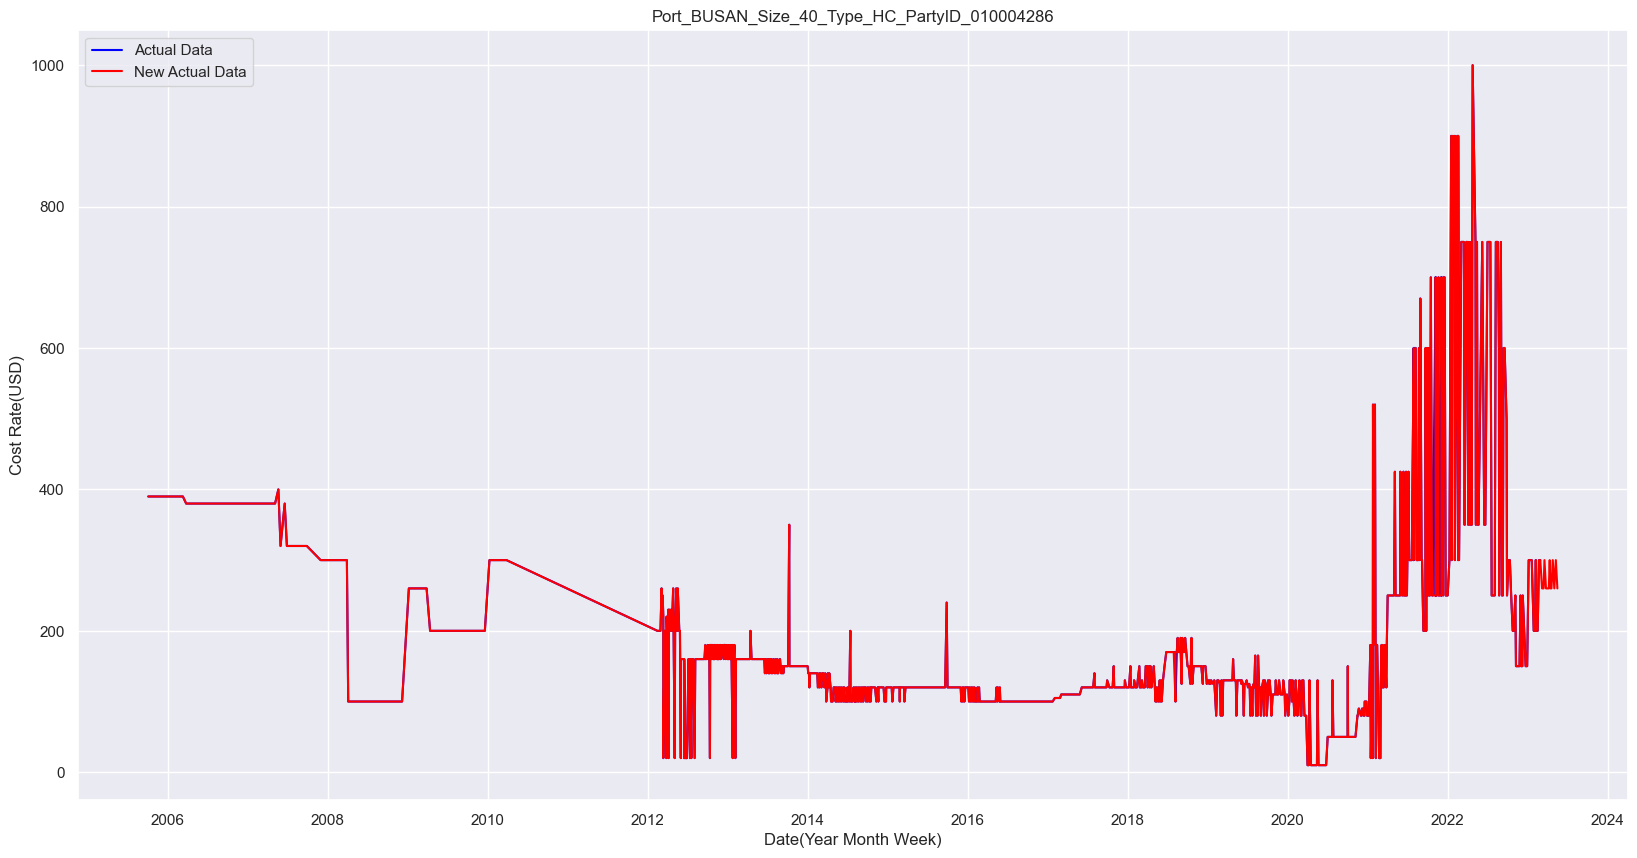

In [379]:
plt.figure(figsize=(20, 10))
plt.plot(sel_feat_df['POD'], sel_feat_df['RATE'], color='blue', label="Actual Data")
plt.plot(latest_sel_df['POD'], latest_sel_df['RATE'], color='red', label="New Actual Data")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show();

<h4>Remove Outliers</h4>

(array([ 37.,   0.,   0.,  31.,   0.,  30., 154.,  45., 235.,  55.,  91.,
         87.,  12.,  35.,  65.,   0.,   8.,   1.,  50.,  13.,   0.,   0.,
         47.,   9.,   0.,   0.,  12.,   0.,  39.,  18.]),
 array([ 10.,  23.,  36.,  49.,  62.,  75.,  88., 101., 114., 127., 140.,
        153., 166., 179., 192., 205., 218., 231., 244., 257., 270., 283.,
        296., 309., 322., 335., 348., 361., 374., 387., 400.]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of RATE')

Text(0.5, 0, 'RATE')

Text(0, 0.5, 'Frequency')

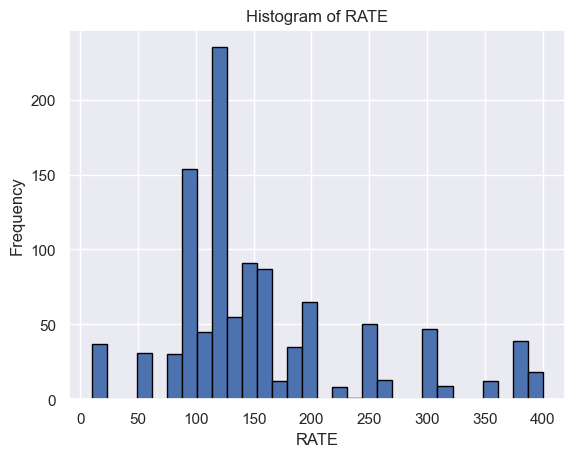

((array([-3.21811506, -2.95446836, -2.80744327, ...,  2.80744327,
          2.95446836,  3.21811506]),
  array([ 10.,  10.,  10., ..., 390., 390., 400.])),
 (78.39380539710916, 158.12849162011173, 0.9305814332436623))

Text(0.5, 1.0, 'Q-Q plot of RATE')

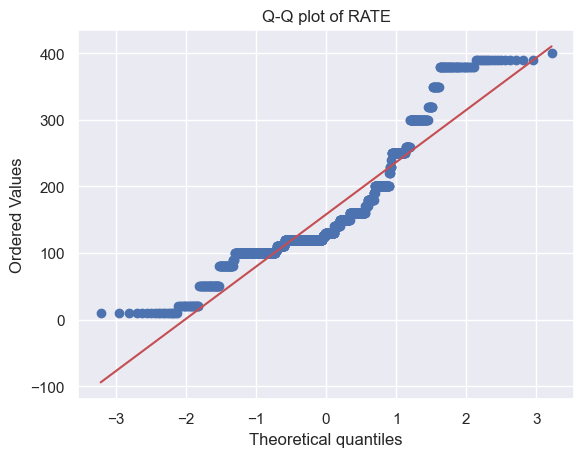

Shapiro-Wilk test:
W: 0.8652241826057434, p-value: 2.1480086253479742e-29
Anderson-Darling test:
Statistic: 57.274165373024516


Data does not look normal (reject H0)
Performing z-score of 3 to remove outliers... 




,POD,RATE
0,2005-10-03,390.0
1,2005-10-07,390.0
2,2005-10-14,390.0
3,2005-10-30,390.0
4,2005-11-03,390.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     1074 non-null   datetime64[ns]
 1   RATE    1074 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.9 KB


In [380]:
# Histogram
plt.hist(robust_df['RATE'], bins=30, edgecolor='black')
plt.title("Histogram of RATE")
plt.xlabel("RATE")
plt.ylabel("Frequency")
plt.show()

# Q-Q plot
stats.probplot(robust_df['RATE'], plot=plt)
plt.title("Q-Q plot of RATE")
plt.show()

# Shapiro-Wilk test
print("Shapiro-Wilk test:")
W, p = stats.shapiro(robust_df['RATE'])
print(f"W: {W}, p-value: {p}")

# Anderson-Darling test
print("Anderson-Darling test:")
result = stats.anderson(robust_df['RATE'])
print(f"Statistic: {result.statistic}")
if result.statistic < result.critical_values[2]: # using a 5% significance level
    print("\n======================================")
    print("\nData looks normal (fail to reject H0)")
    print("Performing Interquartile Range (IQR) to remove outliers...")
    print("======================================\n")

    # IQR
    Q1 = robust_df['RATE'].quantile(0.25)
    Q3 = robust_df['RATE'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    robust_df = robust_df[(robust_df['RATE'] >= lower_bound) & (robust_df['RATE'] <= upper_bound)]

else:
    print("\n======================================")
    print("\nData does not look normal (reject H0)")
    print("Performing z-score of 3 to remove outliers... \n")
    print("======================================\n")

    # z-score
    z_scores = stats.zscore(robust_df['RATE'])
    threshold = 3  # Z-score threshold for outlier detection

    # Remove outliers
    robust_df = robust_df[(np.abs(z_scores) < threshold)]

# Reset the index
robust_df.reset_index(drop=True, inplace=True)

# Print the modified DataFrame
robust_df.head()
robust_df.info()


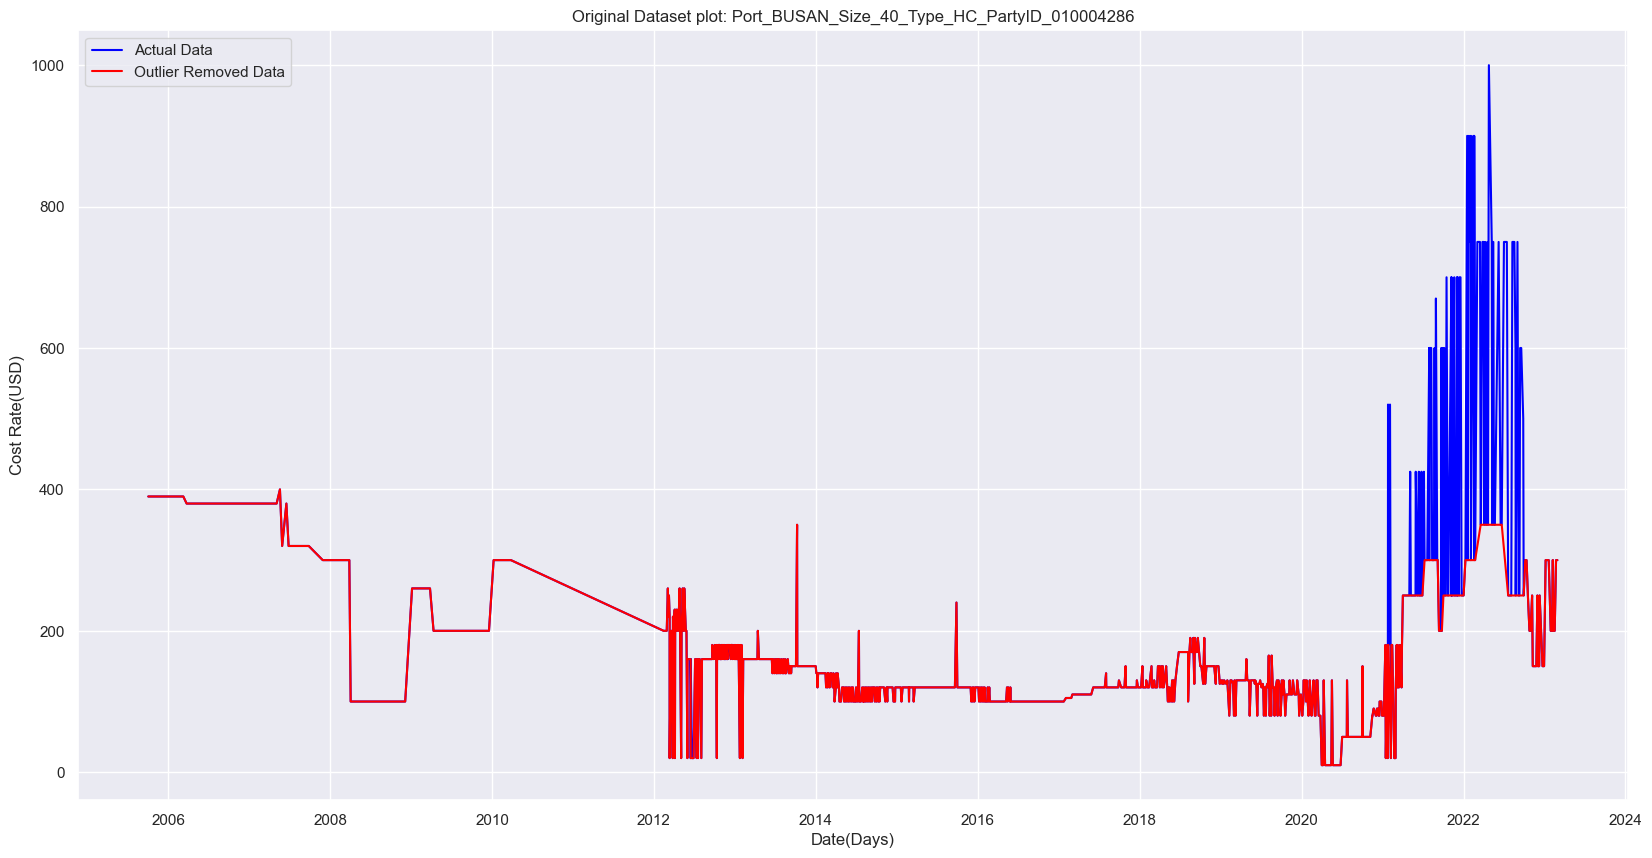

In [381]:
plt.figure(figsize=(20, 10))
plt.plot(sel_feat_df['POD'], sel_feat_df['RATE'], color='blue', label="Actual Data")
plt.plot(robust_df['POD'], robust_df['RATE'], color='red', label="Outlier Removed Data")

plt.xlabel('Date(Days)')
plt.ylabel('Cost Rate(USD)')
plt.title(f'Original Dataset plot: {sel_country}')
plt.legend()
plt.show();

<h4>Interpolate missing values in between dates</h4>

In [382]:
# Remove duplicated dates and cost rows
robust_df = robust_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=robust_df['POD'].min(), end=robust_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, robust_df, on='POD', how='left')  

# Perform interpolation polynomial
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='polynomial', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(3)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-10-03,390.0
1,2005-10-04,390.0
2,2005-10-05,390.0
3,2005-10-06,390.0
4,2005-10-07,390.0


,POD,RATE
6365,2023-02-24,300.0
6366,2023-02-25,300.0
6367,2023-02-26,300.0
6368,2023-02-27,300.0
6369,2023-02-28,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6370 entries, 0 to 6369
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6370 non-null   datetime64[ns]
 1   RATE    6370 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 149.3 KB


<h4>Grouping it to week</h4>

In [383]:
# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated, on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate trimmed mean of RATE values
    # rate_metric = stats.trim_mean(group_df['RATE'].dropna().values, 0.1) # trimming 10% from each end
    if abs(rate_skew) > 0.5:
        rate_metric = group_df['RATE'].median()
    else:
        rate_metric = group_df['RATE'].mean()

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)
agg_df['Rate'] = agg_df['Rate'].round(2)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_868\3163205356.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_868\3163205356.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_868\3163205356.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_868\3163205356.py:43: FutureWarning: The frame.append method is deprecated and will be removed f

,YearMonthWeek,Rate
0,2005-10-03,390.0
1,2005-10-10,390.0
2,2005-10-17,390.0
3,2005-10-24,390.0
4,2005-10-31,390.0
5,2005-11-07,390.0
6,2005-11-14,390.0
7,2005-11-21,390.0
8,2005-11-28,390.0
9,2005-12-05,390.0


,YearMonthWeek,Rate
893,2022-11-14,150.00
894,2022-11-21,150.00
895,2022-11-28,191.43
896,2022-12-05,150.00
897,2022-12-12,211.54
898,2022-12-19,157.69
899,2022-12-26,150.00
900,2023-01-02,278.57
901,2023-01-09,300.00
902,2023-01-16,300.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  908 non-null    datetime64[ns]
 1   Rate           908 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.3 KB


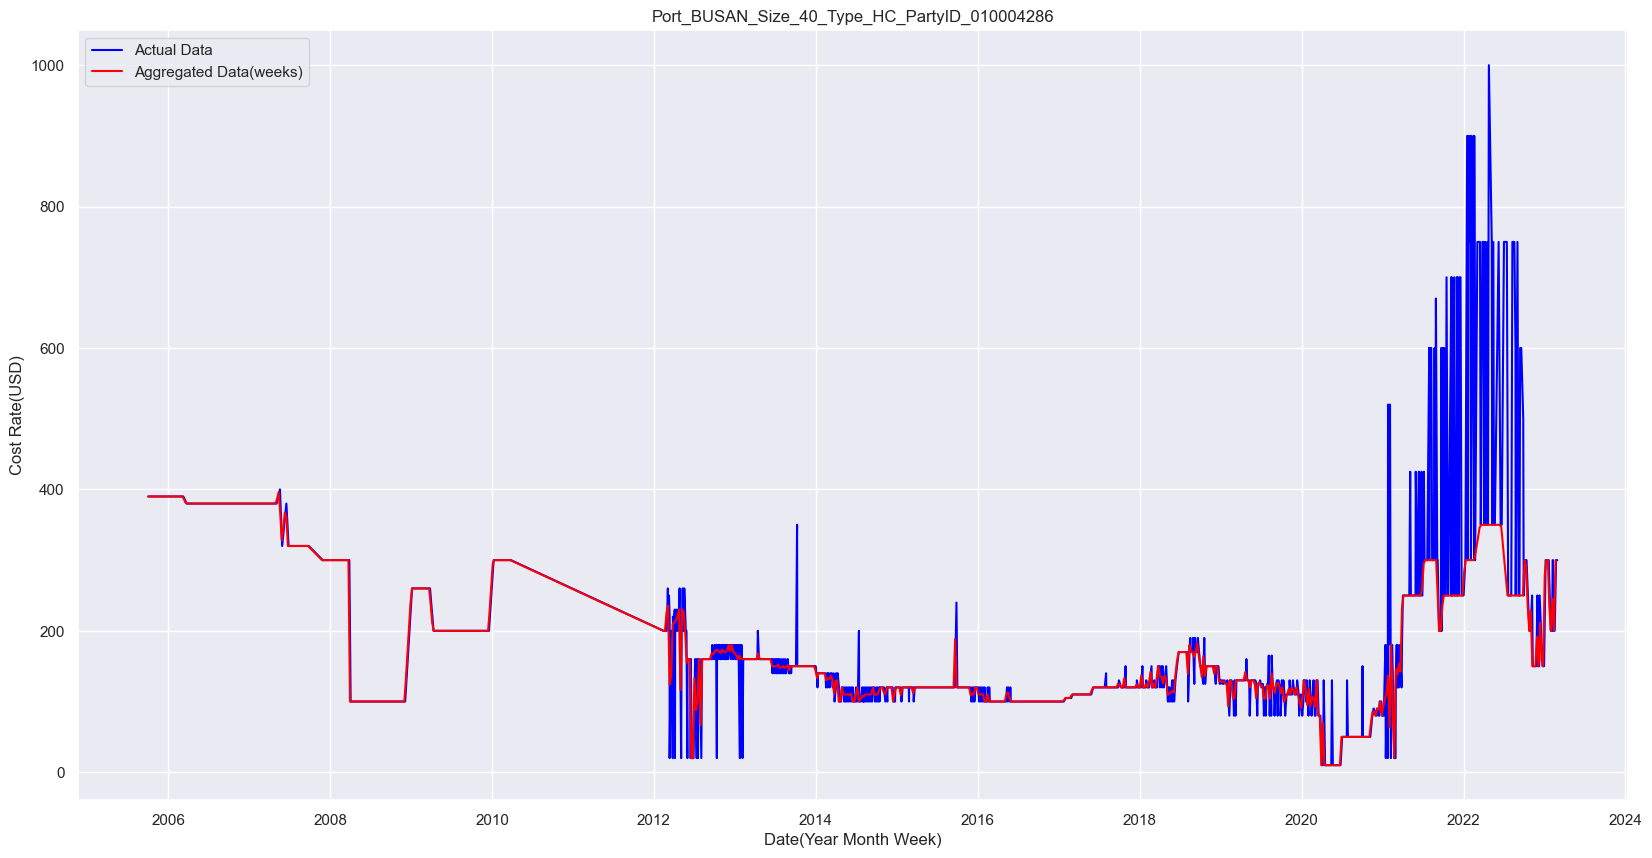

In [384]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show();

<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [385]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200077,010000419950,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
1,ECS010230200077,010000406570,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
2,ECS010230200078,010000432251,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-15,40,HC,260.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
20,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
21,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
22,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      23 non-null     object        
 1   CNTR_ID     23 non-null     object        
 2   POD_ID      23 non-null     object        
 3   ETD_POL_D   23 non-null     object        
 4   PARTY_ID    23 non-null     object        
 5   PARTY_NAME  23 non-null     object        
 6   POD         23 non-null     datetime64[ns]
 7   CNTR_SIZE   23 non-null     object        
 8   CNTR_TYPE   23 non-null     object        
 9   RATE        23 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.9+ KB


<h4>Prepare Features for Feature Engineering</h4>

In [386]:
# Rolling mean for 3 weeks and shift of 1 to avoid lookahead bias
agg_df['Rate_rolled_3w'] = agg_df['Rate'].rolling(window=2, min_periods=0).mean().shift(1)

# Creating temporal features
agg_df['Covid'] = 0
agg_df.loc[(agg_df['YearMonthWeek'] >= '2020-01') & (agg_df['YearMonthWeek'] <= '2023-01'), 'Covid'] = 1

# Creating lag features
for i in range(1, 4):
    agg_df[f'Rate_lag_{i}'] = agg_df['Rate'].shift(i)

# Creating rolling mean and std features
agg_df['Rate_mean_rolled_3w'] = agg_df['Rate'].rolling(window=3).mean().shift(1)
agg_df['Rate_std_rolled_3w'] = agg_df['Rate'].rolling(window=3).std().shift(1)

exogenous_features = ['Rate_rolled_3w', 'Covid', 
                      'Rate_lag_1', 'Rate_lag_2', 'Rate_lag_3',
                      'Rate_mean_rolled_3w', 'Rate_std_rolled_3w']

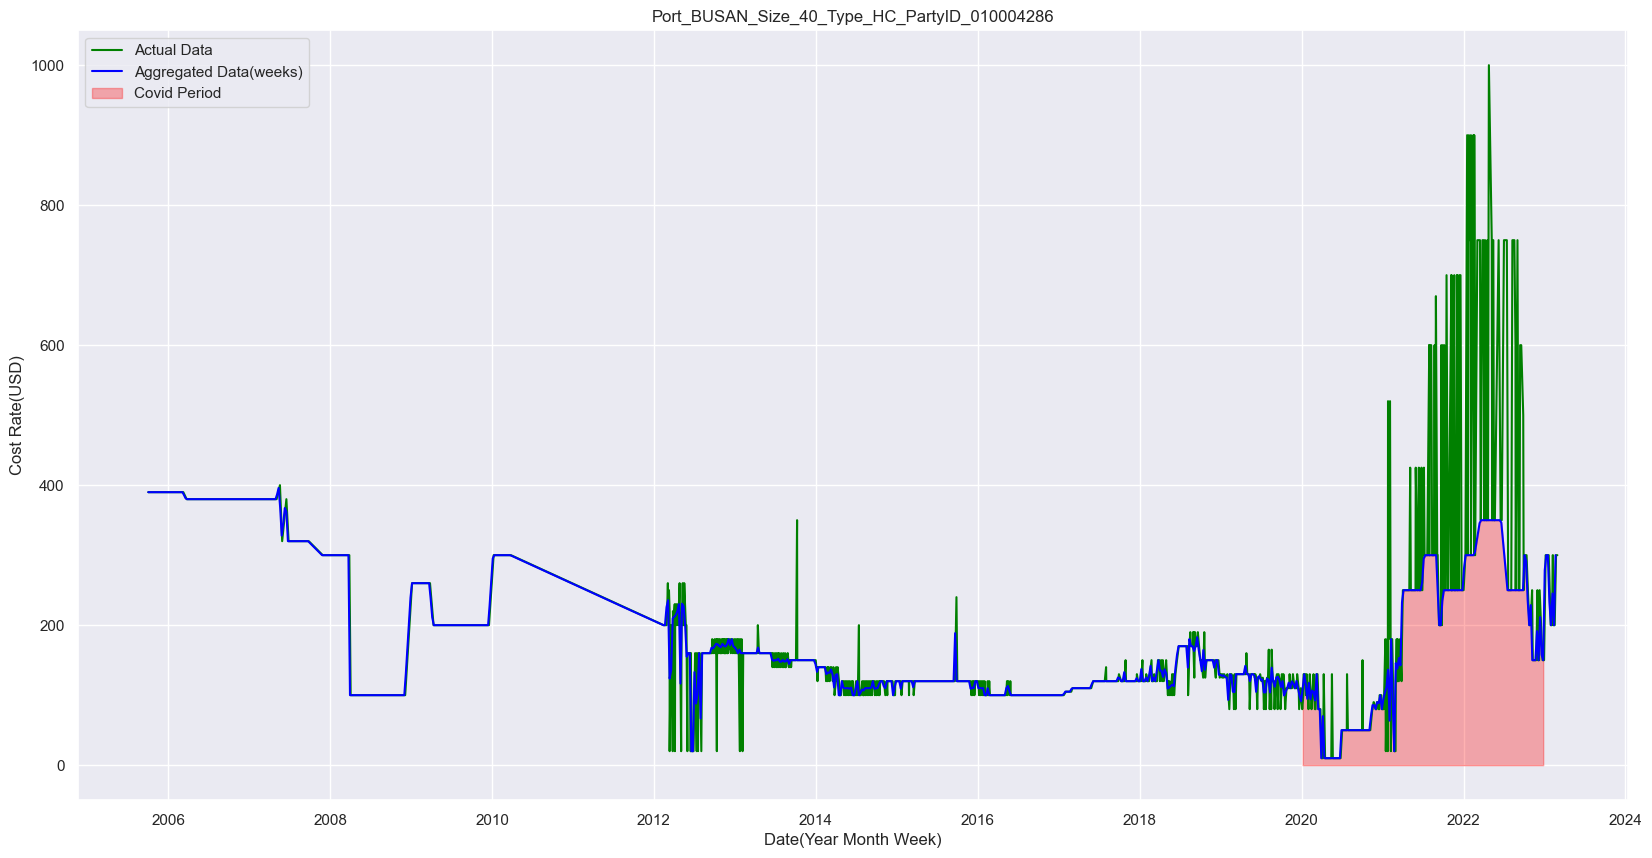

In [387]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='green', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='blue', label="Aggregated Data(weeks)")

# Fill the area between the graph and x-axis when Covid is 1
plt.fill_between(agg_df['YearMonthWeek'], agg_df['Rate'], where=agg_df['Covid'] == 1, color='red', alpha=0.3, label="Covid Period")


plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show();

<h4>ARIMA<h4>

In [388]:
# # Mean Square Error Function:
# def calculate_RMSE(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# # Function to execute Auto ARIMA model and return RMSE on validation set
# def ARIMA_Execute(train, valid):
#     # Fit an auto_arima model
#     arima_model = pm.auto_arima(train, trace=True,
#                                 error_action='ignore',
#                                 suppress_warnings=True,
#                                 stepwise=True)  # set to stepwise
#     # Print the summary of the model
#     print(arima_model.summary())
    
#     # Forecast
#     train_forecast = arima_model.predict_in_sample()
#     valid_forecast = arima_model.predict(n_periods=len(valid))
    
#     # Predict on training, validation and test data
#     train_pred = model.predict(n_periods=len(train))
#     valid_pred = model.predict(n_periods=len(valid))
#     test_pred = model.predict(n_periods=len(test))

#     # Calculate the RMSE
#     RMSE_ARIMA_train = np.sqrt(mean_squared_error(train, train_forecast))
#     print("Train RMSE: %.3f" % RMSE_ARIMA_train)
#     RMSE_ARIMA_valid = np.sqrt(mean_squared_error(valid, valid_forecast))
#     print("Validation RMSE: %.3f" % RMSE_ARIMA_valid)

#     return arima_model, RMSE_ARIMA_train, RMSE_ARIMA_valid



In [389]:
# # Sarimax without train test split

# # Mean Square Error Function:
# def calculate_RMSE(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# # Function to execute Auto ARIMA model and return RMSE on the given data
# def ARIMA_Execute(data):
#     # Fit an auto_arima model
#     arima_model = pm.auto_arima(data, seasonal=True, trace=True,
#                                 error_action='ignore',
#                                 suppress_warnings=True,
#                                 stepwise=True) 
#     # Print the summary of the model
#     print(arima_model.summary())

#     # Forecast
#     data_forecast = arima_model.predict_in_sample()

#     # Calculate the RMSE
#     RMSE_ARIMA_data = calculate_RMSE(data, data_forecast)
#     print("RMSE: %.3f" % RMSE_ARIMA_data)

#     return arima_model, RMSE_ARIMA_data


In [390]:
# Sarimax without train test split and with Feature engineering

# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to execute Auto ARIMA model and return RMSE on the given data
def ARIMA_Execute(endog, exog):
    # Fit an auto_arima model
    arima_model = pm.auto_arima(endog, exogenous=exog, seasonal=True, trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True, alpha=0.07, m=7) 
    # Print the summary of the model
    print(arima_model.summary())

    # Forecast
    data_forecast = arima_model.predict_in_sample(exogenous=exog)

    # Calculate the RMSE
    RMSE_ARIMA_data = calculate_RMSE(endog, data_forecast)
    print("RMSE: %.3f" % RMSE_ARIMA_data)

    return arima_model, RMSE_ARIMA_data

In [391]:
# # For: Sarimax without train test split

# # Get the 'Rate' column values
# data = agg_df['Rate'].values

# # Run ARIMA model
# model, ARIMA_rmse = ARIMA_Execute(data)

# # Evaluate the model on the test set after tuning the parameters with the validation set
# test_forecast = model.predict(n_periods=len(test))
# RMSE_ARIMA_test = np.sqrt(mean_squared_error(test, test_forecast))
# print("Test RMSE: %.3f" % RMSE_ARIMA_test)

In [392]:
# For: Sarimax without train test split but with Feature Engineering

# Get the 'Rate' column values as endogenous variable
endog = agg_df['Rate'].values

# Get the exogenous features
exog = agg_df[exogenous_features].values

# Run ARIMA model
model, ARIMA_rmse = ARIMA_Execute(endog, exog)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=7898.270, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=7968.137, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7912.081, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=7902.278, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=7966.160, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=7899.989, Time=1.00 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=7899.026, Time=0.86 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=7898.232, Time=3.08 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=7896.415, Time=2.38 sec
 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=7895.033, Time=1.11 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=7898.008, Time=0.55 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=7896.869, Time=1.49 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=7897.273, Time=0.87 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=7898.465, Time=0.57 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept

<h4>Forecast the results</h4>

In [393]:
# Add check for 'RATE_actual' values to avoid division by zero
def compute_accuracy(row):
    if row['RATE_actual'] == 0:
        return np.nan
    else:
        error = abs(row['RATE_actual'] - row['RATE_forecasted'])
        error_proportion = error / row['RATE_actual']
        return (1 - error_proportion) * 100


In [394]:
# # Forecast next 12 weeks using ARIMA model
# weeks = 12
# forecasted_values_scaled = model.predict(n_periods=weeks)

# # Inverse transform the forecasted values
# forecasted_values = scaler.inverse_transform(forecasted_values_scaled.reshape(-1, 1))

# # Ensure that 'YearMonthWeek' is a datetime object
# agg_df['YearMonthWeek'] = pd.to_datetime(agg_df['YearMonthWeek'])
# last_date = agg_df['YearMonthWeek'].iloc[-1]
# forecasted_dates = pd.date_range(start=last_date, periods=weeks+1, freq='W')[1:]

# df_forecasted = pd.DataFrame({
#     'POD': forecasted_dates,
#     'RATE': forecasted_values.ravel()
# })

# df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

# df_forecasted.head(5)
# df_forecasted.tail(5)
# df_forecasted.info()

In [395]:
# Forecast next 12 weeks using ARIMA model
weeks = 12
forecasted_values = model.predict(n_periods=weeks)

# Ensure that 'YearMonthWeek' is a datetime object
agg_df['YearMonthWeek'] = pd.to_datetime(agg_df['YearMonthWeek'])
last_date = agg_df['YearMonthWeek'].iloc[-1]
forecasted_dates = pd.date_range(start=last_date, periods=weeks+1, freq='W')[1:]

df_forecasted = pd.DataFrame({
    'POD': forecasted_dates,
    'RATE': forecasted_values.ravel()
})

df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

df_forecasted.head(5)
df_forecasted.tail(5)
df_forecasted.info()

,POD,RATE
0,2023-03-05,283.68
1,2023-03-12,279.16
2,2023-03-19,277.22
3,2023-03-26,279.00
4,2023-04-02,278.91


,POD,RATE
7,2023-04-23,293.54
8,2023-04-30,293.13
9,2023-05-07,287.74
10,2023-05-14,285.29
11,2023-05-21,288.82


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     12 non-null     datetime64[ns]
 1   RATE    12 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 320.0 bytes


<h4>Comparing with actual updated against forecasted</h4>

In [396]:
comparison_df = pd.DataFrame(columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual'])
df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')  

for _, row in df_forecasted.iterrows():
    mask = (new_dates_df['POD'] >= row['POD']) & (new_dates_df['POD'] < row['WeekEnd'])
    actual_dates_within_week = new_dates_df[mask]

    for _, actual_row in actual_dates_within_week.iterrows():
        comparison_df = comparison_df.append({
            'WeekStart': row['POD'],
            'WeekEnd': row['WeekEnd'],
            'POD_actual': actual_row['POD'],
            'RATE_forecasted': row['RATE'],
            'RATE_actual': actual_row['RATE']
        }, ignore_index=True)

# Remove duplicates
comparison_df = comparison_df.drop_duplicates(subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# Compute accuracy
comparison_df['accuracy'] = comparison_df.apply(compute_accuracy, axis=1)
comparison_df = comparison_df.dropna(subset=['accuracy'])

total_mean_accuracy = comparison_df['accuracy'].mean()
comparison_df
print(f'The mean accuracy is {total_mean_accuracy:.2f}%\n')

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_868\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_868\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_868\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_868\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Alo

,WeekStart,WeekEnd,POD_actual,RATE_forecasted,RATE_actual,accuracy
0,2023-03-05,2023-03-12,2023-03-08,283.68,260.0,90.892308
1,2023-03-12,2023-03-19,2023-03-15,279.16,260.0,92.630769
2,2023-03-19,2023-03-26,2023-03-19,277.22,300.0,92.406667
3,2023-03-26,2023-04-02,2023-03-26,279.00,260.0,92.692308
4,2023-03-26,2023-04-02,2023-04-01,279.00,260.0,92.692308
5,2023-04-02,2023-04-09,2023-04-08,278.91,260.0,92.726923
6,2023-04-09,2023-04-16,2023-04-12,274.18,300.0,91.393333
7,2023-04-09,2023-04-16,2023-04-15,274.18,260.0,94.546154
8,2023-04-16,2023-04-23,2023-04-20,293.35,260.0,87.173077
9,2023-04-23,2023-04-30,2023-04-26,293.54,300.0,97.846667


The mean accuracy is 92.19%



<h4>Visualise all, Conclusion</h4>

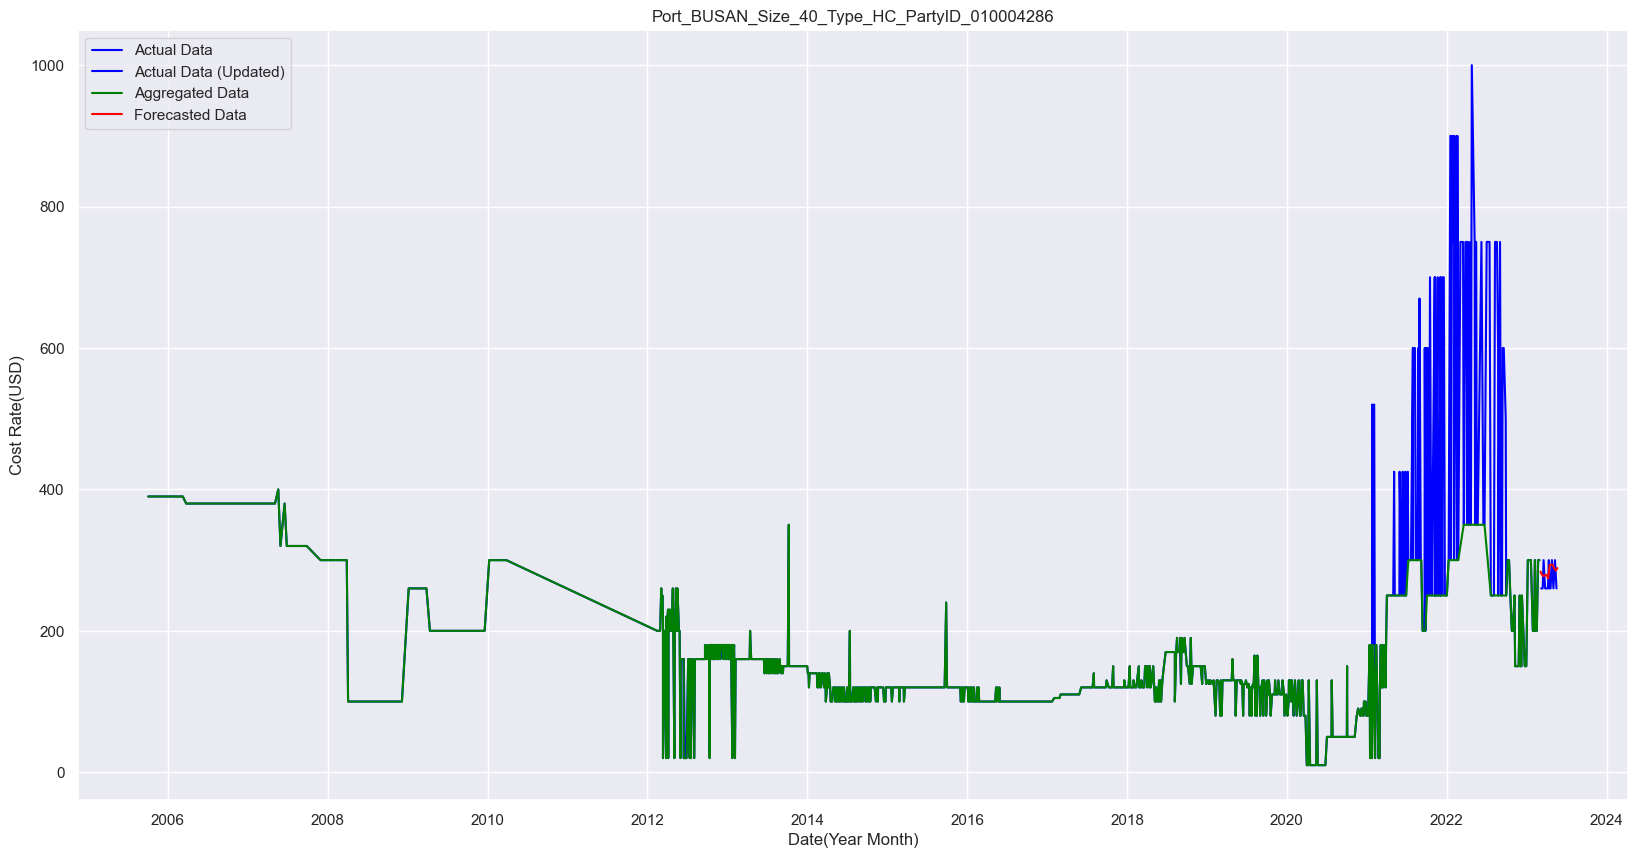

In [397]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(new_dates_df['POD'], new_dates_df['RATE'], color='blue', label="Actual Data (Updated)")

plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show();